In [1]:
from sklearn import datasets, model_selection, linear_model, metrics, preprocessing, svm, neighbors, tree
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline
import math
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter('ignore')

## SMOTE implementation and testing

In [3]:
# function applies SMOTE algorithm to input dataframe using k-neighbours
# inputs: dataframe - pd.DataFrame, last column should comtain labels
#         k - number of neighbors for the algorithm
def smote(dataframe, k, increase_rate=0, imbalanced_label=-1, random_state=0):
    # get the labels of input dataframe
    np.random.seed(random_state)
    labels = dataframe.iloc[:, -1]
    # extract unique labels and count number of examples for each one
    unq_labels, cnt_labels = np.unique(labels, return_counts=True)
    # detect minor class and major class
    unq_labels = list(unq_labels)
    cnt_labels = list(cnt_labels)
    if imbalanced_label == -1:
        imbalanced_label = unq_labels.index(cnt_labels.index(min(cnt_labels)))
    max_label = unq_labels.index(cnt_labels.index(max(cnt_labels)))
    # calculate for how many times minor class should be extended to reach major one
    num_imbalanced = min(cnt_labels)
    num_max_label = max(cnt_labels)
    if increase_rate == 0:
        increase_rate = int(num_max_label / num_imbalanced) - 1
    synth_data = []
    
    # rescale Dataframe values
    columns = dataframe.columns
    labels = np.array(dataframe.iloc[:, -1])
    scaler = preprocessing.MinMaxScaler()
    data = dataframe.iloc[:, :-1]
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    dataframe = pd.DataFrame(scaled_data)
    dataframe['label'] = labels
    
    # extract minor class examples
    imbalanced_class = dataframe.loc[dataframe.iloc[:, -1] == imbalanced_label]
    
    for i in range(num_imbalanced):
        # fit nearest neighbors, number is k + 1 to find k neighbors apart from duplicate which is always the first
        neigh = neighbors.NearestNeighbors(n_neighbors=k + 1)
        neigh.fit(dataframe.iloc[:, :-1], dataframe.iloc[:, -1])
        # find indices of kneighbors in input dataset
        ind_array = neigh.kneighbors(X=[imbalanced_class.iloc[i, :-1]],return_distance=False)
        # generate synthetic datapoints for minor class i-th example
        new_data = populate(dataframe, imbalanced_class, increase_rate, i, ind_array, random_state)
        for j in range(len(new_data)):
            synth_data.append(new_data[j])   
    # process synthetic datapoints and merge with initial dataset        
    synth_data = np.array(synth_data)
    synth_data_dataframe = pd.DataFrame(synth_data)
    synth_data_dataframe.columns = dataframe.iloc[:, :-1].columns
    synth_labels = [imbalanced_label for i in range(synth_data_dataframe.shape[0])]
    synth_data_dataframe['label'] = synth_labels
    new_dataframe = pd.concat([dataframe, synth_data_dataframe])
    
    # inverse scaling 
    labels = np.array(new_dataframe.iloc[:, -1])
    new_data = new_dataframe.iloc[:, :-1]
    scaled_new_data = scaler.inverse_transform(new_data)
    new_dataframe = pd.DataFrame(scaled_new_data)
    new_dataframe['label'] = labels
    new_dataframe.columns = columns
    new_dataframe = new_dataframe.sample(frac=1, random_state=random_state)
    return new_dataframe
 
# function generates synthetic datapoints using a datapoint and its nearest neighbors indices
# inputs: dataframe - initial imbalanced dataframe
#         imbalanced_class - dataframe containing only minor class
#         inc_rate - hom many times minor class should be extended
#         i - index of minor class example
#         ind_array - array containing nearest neighbors indices in initital imbalanced dataframe 
def populate(dataframe, imbalanced_class, inc_rate, i, ind_array, random_state):
    # list for new synthetic data
    np.random.seed(random_state)
    synth_data = []
    while inc_rate != 0:
        # choose random neighbour from 1 to k, ignore 0 because it is duplicate
        rand_k = int(np.random.random() * ind_array[0].shape[0] - 1) + 1
        # list for attributes of one datapoint
        new_datapoint = []
        for attr in range(dataframe.iloc[:, :-1].shape[1]):
            # calculate distance between neighbour and input minor class datapoint
            dist = float(dataframe.iloc[ind_array[:, rand_k], attr]) - float(imbalanced_class.iloc[i, attr])
            gap = np.random.random()
            # add attribute for synthetic datapoint
            new_datapoint.append(imbalanced_class.iloc[i, attr] + gap * dist)
        # append datapoint to the list with synthetic datapoints    
        synth_data.append(new_datapoint)
        inc_rate -= 1
    return synth_data     

In [4]:
def plot_blobs(blobs, title):
    label_0 = blobs.loc[blobs['label'] == 0]
    label_1 = blobs.loc[blobs['label'] == 1]
    plt.title(title)
    plt.scatter(label_0.x1, label_0.x2, marker='o')
    plt.scatter(label_1.x1, label_1.x2, marker='x')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

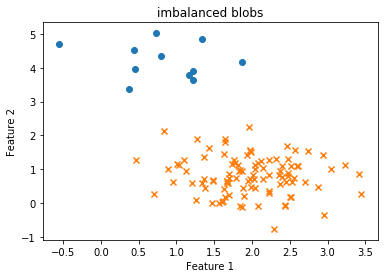

In [5]:
blobs = pd.read_csv('./imbalanced_datasets/imbalanced_blobs.csv')
plot_blobs(blobs, 'imbalanced blobs')

Number of class 0 after SMOTE: 99
Number of class 1 after SMOTE: 100


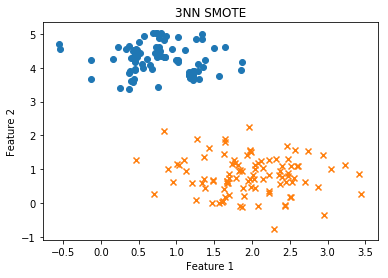

In [6]:
smote_blobs_3 = smote(blobs, 3)
print 'Number of class 0 after SMOTE:', smote_blobs_3.loc[smote_blobs_3['label'] == 0].shape[0]
print 'Number of class 1 after SMOTE:', smote_blobs_3.loc[smote_blobs_3['label'] == 1].shape[0]
plot_blobs(smote_blobs_3, '3NN SMOTE')

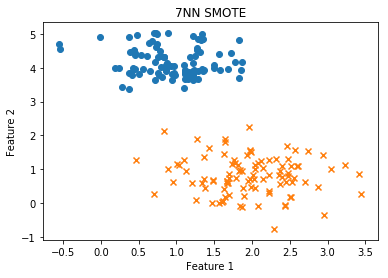

In [7]:
smote_blobs_7 = smote(blobs, 7)
plot_blobs(smote_blobs_7, '7NN SMOTE')

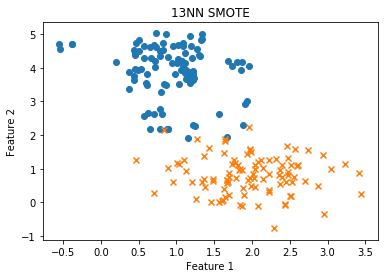

In [8]:
smote_blobs_13 = smote(blobs, 13)
plot_blobs(smote_blobs_13, '13NN SMOTE')

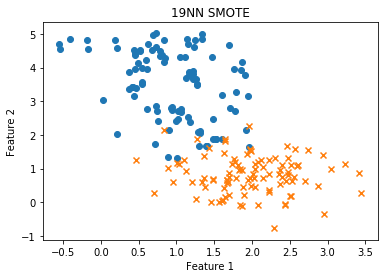

In [9]:
smote_blobs_19 = smote(blobs, 19)
plot_blobs(smote_blobs_19, '19NN SMOTE')

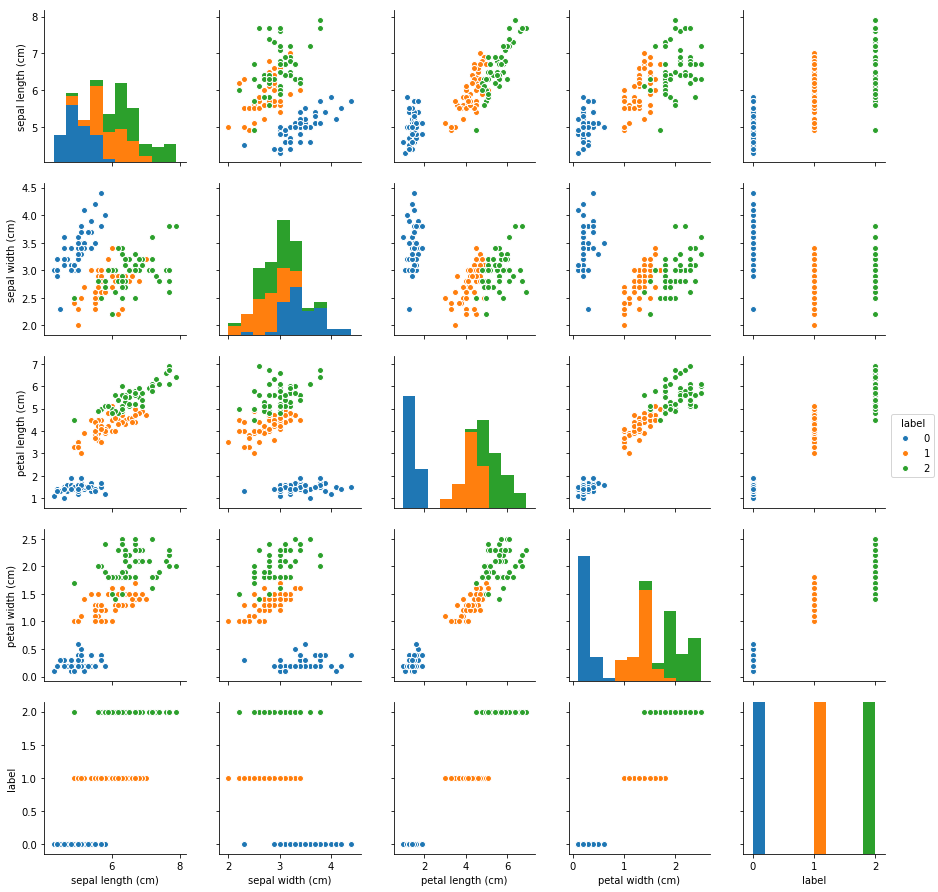

In [10]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data)
iris_df.columns = iris.feature_names
iris_df['label'] = iris.target
sns.pairplot(iris_df, hue='label')

In [11]:
iris_imb = pd.read_csv('./imbalanced_datasets/imbalanced_iris01.csv')

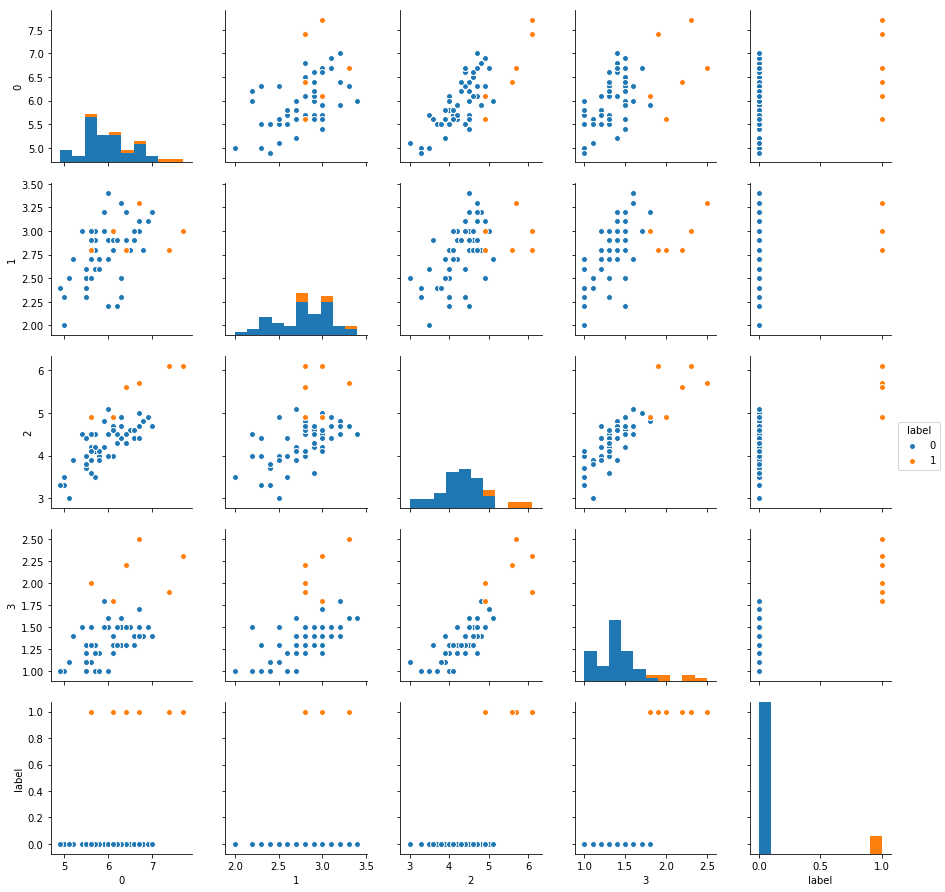

In [12]:
sns.pairplot(iris_imb, hue='label')

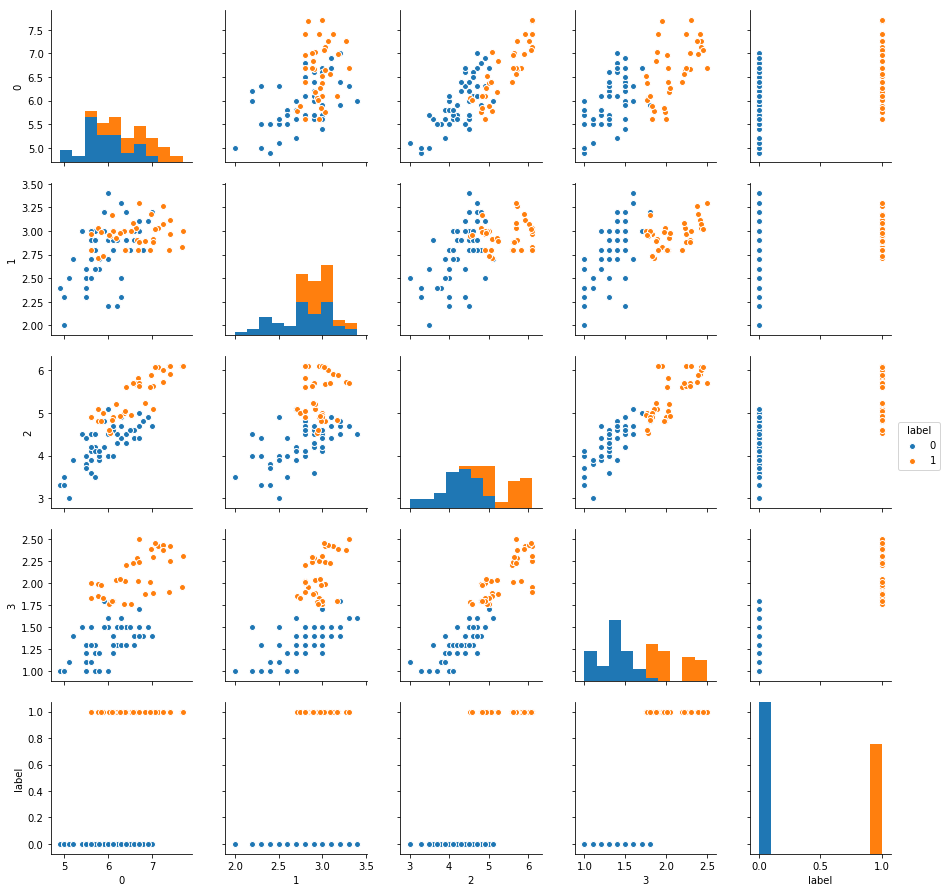

In [13]:
iris_smote = smote(iris_imb, 3, 5, 1)
sns.pairplot(iris_smote, hue='label')

## Training and Testing 

### Functions

In [5]:
# function for calculate precision, recall and F-measure using One VS All technique. Returns the measures for each label.
def get_prc_rcl(conf_matrix, interesting_class=1):
    print(conf_matrix.round(3).T)
    prc = round(conf_matrix[interesting_class][interesting_class] * 1.0 / sum(conf_matrix[:, interesting_class]), 3)
    rcl = round(conf_matrix[interesting_class][interesting_class] * 1.0 / sum(conf_matrix[interesting_class]), 3)
    if math.isnan(prc):
        prc = 0
    if math.isnan(rcl):
        rcl = 0    
    if prc == 0 and rcl == 0:
        f_meas = 0
    else:
        f_meas = round(2 * (prc * rcl / (prc + rcl)), 3)
    return prc, rcl, f_meas

In [6]:
# function for training and testing a model
def train_model(clf_name, data, target, labels=[0, 1], random_state=0, cv=5, n_iter=100, interesting_class=1, \
                apply_smote=False, smote_inc_rate=0, knn_smote=3, standard=True):
    # CV init
    cv = model_selection.KFold(n_splits=cv,random_state=random_state)
    # list for accuracies
    accs = []
    # confusion matrix init
    conf_matr = np.zeros((np.unique(target).size, np.unique(target).size))
    # cross validation loop
    for train_inds, test_inds in cv.split(data):
        # initialize classifier
        if clf_name == 'log':
            clf = linear_model.SGDClassifier(random_state=random_state, n_iter=n_iter)
        if clf_name == 'svm':
            clf = svm.SVC(kernel='rbf', random_state=random_state)
        if clf_name == '5nn':
            clf = neighbors.KNeighborsClassifier(n_neighbors=5)
        if clf_name == 'tree':
            clf = tree.DecisionTreeClassifier(max_depth=10, random_state=random_state)
        # separate train folds and test fold
        train_data = data[train_inds]
        train_labels = target[train_inds]
        test_data = data[test_inds]
        test_labels = target[test_inds]
        # SMOTE
        if apply_smote:
            train_df = pd.DataFrame(train_data)
            train_df['label'] = train_labels
            smote_train_df = smote(train_df, knn_smote, smote_inc_rate, interesting_class)
            train_data = np.array(smote_train_df.iloc[:, :-1])
            train_labels = np.array(smote_train_df.iloc[:, -1])
        # standartization
        if standard:
            scaler = preprocessing.MinMaxScaler().fit(train_data)
            train_data = scaler.transform(train_data)
            test_data = scaler.transform(test_data)
        # training  
        clf.fit(train_data, train_labels)
        # measure results: accuracy and confusion matrix
        accs.append(clf.score(test_data, test_labels))
        conf_matr += metrics.confusion_matrix(y_true=test_labels, y_pred=clf.predict(test_data), labels=labels)
    # calculate mean accuracy, precision, rcl, f_meas
    mean_acc = np.array(accs).mean()
    prcs, rcls, f_meas = get_prc_rcl(conf_matrix=conf_matr, interesting_class=interesting_class)  
    return mean_acc, prcs, rcls, f_meas, conf_matr

In [7]:
def test_dataset(data, target, name, labels=[0, 1], classifiers = ['log', 'svm', '5nn', 'tree'], cv=5, n_iter=100, \
                 apply_smote=False, knn_smote=3, \
                 smote_inc_rate=0, standard=True, interesting_class=1):
    columns = ['dataset', 'algorithm', 'mean accuracy', 'precision', 'recall', 'F-measure']
    df = pd.DataFrame(columns=columns)    
    for clf in classifiers:
        print(clf, 'is running')
        
        acc, prc, rcl, f_meas, conf_matr = train_model(clf_name=clf, data=data, target=target, cv=cv, \
                                                         n_iter=n_iter,\
                                                         apply_smote=apply_smote, \
                                                         knn_smote=knn_smote, smote_inc_rate=smote_inc_rate, \
                                                         standard=standard, labels=labels, interesting_class=interesting_class)
        
        row = [name, clf, round(acc, 3), prc, rcl, f_meas]
        df.loc[classifiers.index(clf)] = row
    return df        

## Datasets

### Train and test on balanced, imbalanced and with SMOTE increase rate 1

### Breast Cancer

In [17]:
bc = datasets.load_breast_cancer()
test_dataset(bc.data, bc.target, name = 'bc', standard=True, interesting_class=1)

('log', 'is running')
[[200.   7.]
 [ 12. 350.]]
('svm', 'is running')
[[179.   1.]
 [ 33. 356.]]
('5nn', 'is running')
[[196.   6.]
 [ 16. 351.]]
('tree', 'is running')
[[190.  33.]
 [ 22. 324.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,bc,log,0.967,0.967,0.980,0.973
1,bc,svm,0.940,0.915,0.997,0.954
2,bc,5nn,0.961,0.956,0.983,0.969
3,bc,tree,0.903,0.936,0.908,0.922


In [18]:
imb_bc = pd.read_csv('./imbalanced_datasets/imbalanced_breast_cancer.csv')
imb_bc_data = np.array(imb_bc.iloc[:,:-1])
imb_bc_label = np.array(imb_bc.iloc[:,-1])
# print(imb_bc.loc[imb_bc['label'] == 0].shape[0])
test_dataset(imb_bc_data, imb_bc_label, name='imb_bc', standard=True)

('log', 'is running')
[[208.   6.]
 [  4.  18.]]
('svm', 'is running')
[[212.  24.]
 [  0.   0.]]
('5nn', 'is running')
[[210.   7.]
 [  2.  17.]]
('tree', 'is running')
[[209.   7.]
 [  3.  17.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,imb_bc,log,0.958,0.818,0.750,0.783
1,imb_bc,svm,0.898,0.000,0.000,0.000
2,imb_bc,5nn,0.962,0.895,0.708,0.791
3,imb_bc,tree,0.958,0.850,0.708,0.773


In [19]:
test_dataset(imb_bc_data, imb_bc_label, name='smote_bc', apply_smote=True, smote_inc_rate=1, standard=True)

('log', 'is running')
[[205.   3.]
 [  7.  21.]]
('svm', 'is running')
[[212.  22.]
 [  0.   2.]]
('5nn', 'is running')
[[208.   6.]
 [  4.  18.]]
('tree', 'is running')
[[208.   4.]
 [  4.  20.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,smote_bc,log,0.958,0.750,0.875,0.808
1,smote_bc,svm,0.907,1.000,0.083,0.153
2,smote_bc,5nn,0.958,0.818,0.750,0.783
3,smote_bc,tree,0.966,0.833,0.833,0.833


### Iris

In [20]:
iris_0 = pd.read_csv('./binary_datasets/iris01.csv')
iris_data = iris_0.iloc[:,:-1]
iris_labels = iris_0.iloc[:, -1]
test_dataset(np.array(iris_data), np.array(iris_labels), name = 'iris', labels = [0, 1], standard=True)

('log', 'is running')
[[46.  1.]
 [ 4. 49.]]
('svm', 'is running')
[[46.  9.]
 [ 4. 41.]]
('5nn', 'is running')
[[46.  4.]
 [ 4. 46.]]
('tree', 'is running')
[[46.  5.]
 [ 4. 45.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,iris,log,0.95,0.925,0.98,0.952
1,iris,svm,0.87,0.911,0.82,0.863
2,iris,5nn,0.92,0.920,0.92,0.920
3,iris,tree,0.91,0.918,0.90,0.909


In [21]:
imb_iris = pd.read_csv('./imbalanced_datasets/imbalanced_iris01.csv')
imb_iris_data = np.array(imb_iris.iloc[:,:-1])
imb_iris_label = np.array(imb_iris.iloc[:,-1])
test_dataset(imb_iris_data, imb_iris_label, name='imb_iris', standard=True)

('log', 'is running')
[[50.  1.]
 [ 0.  5.]]
('svm', 'is running')
[[50.  6.]
 [ 0.  0.]]
('5nn', 'is running')
[[50.  2.]
 [ 0.  4.]]
('tree', 'is running')
[[49.  0.]
 [ 1.  6.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,imb_iris,log,0.983,1.000,0.833,0.909
1,imb_iris,svm,0.894,0.000,0.000,0.000
2,imb_iris,5nn,0.965,1.000,0.667,0.800
3,imb_iris,tree,0.983,0.857,1.000,0.923


In [22]:
test_dataset(imb_iris_data, imb_iris_label, name='smote_iris', apply_smote=True, smote_inc_rate=1, standard=True)

('log', 'is running')
[[49.  0.]
 [ 1.  6.]]
('svm', 'is running')
[[50.  3.]
 [ 0.  3.]]
('5nn', 'is running')
[[50.  2.]
 [ 0.  4.]]
('tree', 'is running')
[[49.  0.]
 [ 1.  6.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,smote_iris,log,0.983,0.857,1.000,0.923
1,smote_iris,svm,0.947,1.000,0.500,0.667
2,smote_iris,5nn,0.965,1.000,0.667,0.800
3,smote_iris,tree,0.983,0.857,1.000,0.923


### Wine

In [23]:
wine_0 = pd.read_csv('./binary_datasets/wine01.csv')
wine_data = wine_0.iloc[:,:-1]
wine_labels = wine_0.iloc[:, -1]
test_dataset(np.array(iris_data), np.array(iris_labels), name = 'wine', standard=True)

('log', 'is running')
[[46.  1.]
 [ 4. 49.]]
('svm', 'is running')
[[46.  9.]
 [ 4. 41.]]
('5nn', 'is running')
[[46.  4.]
 [ 4. 46.]]
('tree', 'is running')
[[46.  5.]
 [ 4. 45.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,wine,log,0.95,0.925,0.98,0.952
1,wine,svm,0.87,0.911,0.82,0.863
2,wine,5nn,0.92,0.920,0.92,0.920
3,wine,tree,0.91,0.918,0.90,0.909


In [24]:
imb_wine = pd.read_csv('./imbalanced_datasets/imbalanced_wine01.csv')
imb_wine_data = np.array(imb_wine.iloc[:,:-1])
imb_wine_label = np.array(imb_wine.iloc[:,-1])
test_dataset(imb_wine_data, imb_wine_label, name='imb_wine', standard=True)

('log', 'is running')
[[59.  2.]
 [ 0.  5.]]
('svm', 'is running')
[[59.  7.]
 [ 0.  0.]]
('5nn', 'is running')
[[59.  3.]
 [ 0.  4.]]
('tree', 'is running')
[[59.  2.]
 [ 0.  5.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,imb_wine,log,0.970,1.0,0.714,0.833
1,imb_wine,svm,0.893,0.0,0.000,0.000
2,imb_wine,5nn,0.955,1.0,0.571,0.727
3,imb_wine,tree,0.969,1.0,0.714,0.833


In [25]:
test_dataset(imb_wine_data, imb_wine_label, name='smote_wine', apply_smote=True, smote_inc_rate=1, standard=True)

('log', 'is running')
[[55.  0.]
 [ 4.  7.]]
('svm', 'is running')
[[59.  7.]
 [ 0.  0.]]
('5nn', 'is running')
[[59.  2.]
 [ 0.  5.]]
('tree', 'is running')
[[57.  0.]
 [ 2.  7.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,smote_wine,log,0.942,0.636,1.000,0.778
1,smote_wine,svm,0.893,0.000,0.000,0.000
2,smote_wine,5nn,0.970,1.000,0.714,0.833
3,smote_wine,tree,0.969,0.778,1.000,0.875


### Yeast

In [26]:
yeastCYT = pd.read_csv('./binary_datasets/yeastCYTNUC.csv')
yeast_data = yeastCYT.iloc[:,:-1]
yeast_labels = yeastCYT.iloc[:, -1]
test_dataset(np.array(yeast_data), np.array(yeast_labels), name = 'yeast', standard=True)

('log', 'is running')
[[246. 166.]
 [183. 297.]]
('svm', 'is running')
[[102.  58.]
 [327. 405.]]
('5nn', 'is running')
[[232. 171.]
 [197. 292.]]
('tree', 'is running')
[[236. 190.]
 [193. 273.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,yeast,log,0.609,0.619,0.641,0.630
1,yeast,svm,0.568,0.553,0.875,0.678
2,yeast,5nn,0.588,0.597,0.631,0.614
3,yeast,tree,0.571,0.586,0.590,0.588


In [27]:
imb_yeastCYT = pd.read_csv('./imbalanced_datasets/imbalanced_yeastCYTNUC.csv')
imb_yeast_data = imb_yeastCYT.iloc[:,:-1]
imb_yeast_label = imb_yeastCYT.iloc[:, -1]
test_dataset(np.array(imb_yeast_data), np.array(imb_yeast_label), name = 'imb_yeast', standard=True)

('log', 'is running')
[[429.  48.]
 [  0.   0.]]
('svm', 'is running')
[[429.  48.]
 [  0.   0.]]
('5nn', 'is running')
[[423.  46.]
 [  6.   2.]]
('tree', 'is running')
[[390.  37.]
 [ 39.  11.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,imb_yeast,log,0.899,0,0.000,0
1,imb_yeast,svm,0.899,0,0.000,0
2,imb_yeast,5nn,0.891,0.25,0.042,0.072
3,imb_yeast,tree,0.841,0.22,0.229,0.224


In [28]:
test_dataset(np.array(imb_yeast_data), np.array(imb_yeast_label), name = 'smote_yeast', standard=True, \
             apply_smote=True, smote_inc_rate=1)

('log', 'is running')
[[427.  47.]
 [  2.   1.]]
('svm', 'is running')
[[429.  48.]
 [  0.   0.]]
('5nn', 'is running')
[[389.  37.]
 [ 40.  11.]]
('tree', 'is running')
[[385.  39.]
 [ 44.   9.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,smote_yeast,log,0.897,0.333,0.021,0.040
1,smote_yeast,svm,0.899,0.000,0.000,0.000
2,smote_yeast,5nn,0.839,0.216,0.229,0.222
3,smote_yeast,tree,0.826,0.170,0.188,0.179


### Avila

In [29]:
avilaHX = pd.read_csv('./binary_datasets/avilaHX.csv')
avila_data = avilaHX.iloc[:,:-1]
avila_labels = avilaHX.iloc[:, -1]
test_dataset(np.array(avila_data), np.array(avila_labels), name = 'avila', standard=True)

('log', 'is running')
[[1007.   32.]
 [  32. 1012.]]
('svm', 'is running')
[[1033.   65.]
 [   6.  979.]]
('5nn', 'is running')
[[1035.   23.]
 [   4. 1021.]]
('tree', 'is running')
[[1039.    0.]
 [   0. 1044.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,avila,log,0.969,0.969,0.969,0.969
1,avila,svm,0.966,0.994,0.938,0.965
2,avila,5nn,0.987,0.996,0.978,0.987
3,avila,tree,1.000,1.000,1.000,1.000


In [30]:
imb_avilaHX = pd.read_csv('./imbalanced_datasets/imbalanced_avilaHX.csv')
imb_avila_data = imb_avilaHX.iloc[:,:-1]
imb_avila_labels = imb_avilaHX.iloc[:, -1]
test_dataset(np.array(imb_avila_data), np.array(imb_avila_labels), name = 'imb_avila', standard=True)

('log', 'is running')
[[1039.   15.]
 [   0.  100.]]
('svm', 'is running')
[[1039.   85.]
 [   0.   30.]]
('5nn', 'is running')
[[1039.   17.]
 [   0.   98.]]
('tree', 'is running')
[[1036.    3.]
 [   3.  112.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,imb_avila,log,0.987,1.000,0.870,0.930
1,imb_avila,svm,0.926,1.000,0.261,0.414
2,imb_avila,5nn,0.985,1.000,0.852,0.920
3,imb_avila,tree,0.995,0.974,0.974,0.974


In [31]:
test_dataset(np.array(imb_avila_data), np.array(imb_avila_labels), name = 'smote_avila', standard=True, \
            apply_smote=True, smote_inc_rate=1)

('log', 'is running')
[[1039.   16.]
 [   0.   99.]]
('svm', 'is running')
[[1039.   42.]
 [   0.   73.]]
('5nn', 'is running')
[[1.038e+03 1.000e+01]
 [1.000e+00 1.050e+02]]
('tree', 'is running')
[[1.037e+03 1.000e+00]
 [2.000e+00 1.140e+02]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,smote_avila,log,0.986,1.000,0.861,0.925
1,smote_avila,svm,0.964,1.000,0.635,0.777
2,smote_avila,5nn,0.990,0.991,0.913,0.950
3,smote_avila,tree,0.997,0.983,0.991,0.987


### Wireless Indoor Localization

In [12]:
wil = pd.read_csv('./binary_datasets/wil_2_3.csv')
wil_data = wil.iloc[:,:-1]
wil_labels = wil.iloc[:, -1]
test_dataset(np.array(wil_data), np.array(wil_labels), name = 'wil', standard=True,n_iter=10000)

log is running
[[467.  32.]
 [ 33. 468.]]
svm is running
[[453.  27.]
 [ 47. 473.]]
5nn is running
[[457.  24.]
 [ 43. 476.]]
tree is running
[[446.  46.]
 [ 54. 454.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,wil,log,0.935,0.934,0.936,0.935
1,wil,svm,0.926,0.910,0.946,0.928
2,wil,5nn,0.933,0.917,0.952,0.934
3,wil,tree,0.900,0.894,0.908,0.901


In [13]:
imb_wil = pd.read_csv('./imbalanced_datasets/imbalanced_wil_2_3.csv')
imb_wil_data = imb_wil.iloc[:,:-1]
imb_wil_label = imb_wil.iloc[:, -1]
test_dataset(np.array(imb_wil_data), np.array(imb_wil_label), name = 'imb_wil', standard=True, n_iter=10000)

log is running
[[494.   7.]
 [  6.  49.]]
svm is running
[[499.  28.]
 [  1.  28.]]
5nn is running
[[495.  10.]
 [  5.  46.]]
tree is running
[[487.  14.]
 [ 13.  42.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,imb_wil,log,0.977,0.891,0.875,0.883
1,imb_wil,svm,0.948,0.966,0.500,0.659
2,imb_wil,5nn,0.973,0.902,0.821,0.860
3,imb_wil,tree,0.951,0.764,0.750,0.757


In [14]:
test_dataset(np.array(imb_wil_data), np.array(imb_wil_label), name = 'smote_wil', standard=True, \
             apply_smote=True, smote_inc_rate=1)

log is running
[[481.   6.]
 [ 19.  50.]]
svm is running
[[487.   5.]
 [ 13.  51.]]
5nn is running
[[488.   6.]
 [ 12.  50.]]
tree is running
[[485.  14.]
 [ 15.  42.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,smote_wil,log,0.955,0.725,0.893,0.800
1,smote_wil,svm,0.968,0.797,0.911,0.850
2,smote_wil,5nn,0.968,0.806,0.893,0.847
3,smote_wil,tree,0.948,0.737,0.750,0.743


### Testing SMOTE on imbalanced datasets against different increase rates

In [10]:
def test_against_inc_rate(data, target, name, labels=[0, 1], classifiers = ['log', 'svm', '5nn', 'tree'], cv=5, n_iter=100, \
                 apply_smote=False, knn_smote=3, higher_smote_inc_rate=1, standard=True, interesting_class=0):
    precisions_dict = {clf: list() for clf in classifiers}
    recalls_dict = {clf: list() for clf in classifiers}
    for inc_rate in range(higher_smote_inc_rate + 1):
        print '---'
        if inc_rate != 0:
            df = test_dataset(np.array(data), np.array(target), name = name, labels = labels, classifiers=classifiers, \
                          standard=True, apply_smote=True, n_iter=n_iter, smote_inc_rate=inc_rate)
        else:
            df = test_dataset(np.array(data), np.array(target), name = name, labels = labels, classifiers=classifiers, \
                          standard=True, n_iter=n_iter)
        for i in range(df.shape[0]):
            tmp_prec_list = precisions_dict.get(df.iloc[i, 1])
            tmp_prec_list.append(df.iloc[i, 3])
            precisions_dict[df.iloc[i, 1]] = tmp_prec_list
            tmp_rec_list = recalls_dict.get(df.iloc[i, 1])
            tmp_rec_list.append(df.iloc[i, 4])
            recalls_dict[df.iloc[i, 1]] = tmp_rec_list
    return precisions_dict, recalls_dict

#### Breast cancer

In [33]:
bc_precision_dict, bc_recall_dict = test_against_inc_rate(imb_bc_data, imb_bc_label, name='smote_bc', \
                                                          apply_smote=True, higher_smote_inc_rate=10, standard=True)

---
('log', 'is running')
[[208.   6.]
 [  4.  18.]]
('svm', 'is running')
[[212.  24.]
 [  0.   0.]]
('5nn', 'is running')
[[210.   7.]
 [  2.  17.]]
('tree', 'is running')
[[209.   7.]
 [  3.  17.]]
---
('log', 'is running')
[[205.   3.]
 [  7.  21.]]
('svm', 'is running')
[[212.  22.]
 [  0.   2.]]
('5nn', 'is running')
[[208.   6.]
 [  4.  18.]]
('tree', 'is running')
[[208.   4.]
 [  4.  20.]]
---
('log', 'is running')
[[199.   2.]
 [ 13.  22.]]
('svm', 'is running')
[[209.   5.]
 [  3.  19.]]
('5nn', 'is running')
[[202.   4.]
 [ 10.  20.]]
('tree', 'is running')
[[209.   4.]
 [  3.  20.]]
---
('log', 'is running')
[[203.   4.]
 [  9.  20.]]
('svm', 'is running')
[[206.   4.]
 [  6.  20.]]
('5nn', 'is running')
[[199.   4.]
 [ 13.  20.]]
('tree', 'is running')
[[207.   4.]
 [  5.  20.]]
---
('log', 'is running')
[[200.   3.]
 [ 12.  21.]]
('svm', 'is running')
[[198.   2.]
 [ 14.  22.]]
('5nn', 'is running')
[[196.   4.]
 [ 16.  20.]]
('tree', 'is running')
[[200.   4.]
 [ 12.  2

In [34]:
print 'Precisions for breast cancer dataset', bc_precision_dict
print 'Recalls for breast cancer dataset', bc_recall_dict

Precisions for breast cancer dataset {'svm': [0.0, 1.0, 0.864, 0.769, 0.611, 0.564, 0.564, 0.5, 0.479, 0.451, 0.451], 'tree': [0.85, 0.833, 0.87, 0.8, 0.625, 0.541, 0.645, 0.545, 0.516, 0.613, 0.559], 'log': [0.818, 0.75, 0.629, 0.69, 0.636, 0.6, 0.636, 0.583, 0.449, 0.629, 0.595], '5nn': [0.895, 0.818, 0.667, 0.606, 0.556, 0.526, 0.488, 0.476, 0.489, 0.46, 0.442]}
Recalls for breast cancer dataset {'svm': [0.0, 0.083, 0.792, 0.833, 0.917, 0.917, 0.917, 0.958, 0.958, 0.958, 0.958], 'tree': [0.708, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.75, 0.667, 0.792, 0.792], 'log': [0.75, 0.875, 0.917, 0.833, 0.875, 0.875, 0.875, 0.875, 0.917, 0.917, 0.917], '5nn': [0.708, 0.75, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.917, 0.958, 0.958]}


#### Iris

In [35]:
iris_precision_dict, iris_recall_dict = test_against_inc_rate(imb_iris_data, imb_iris_label, name='smote_iris', \
                                                          apply_smote=True, higher_smote_inc_rate=10, standard=True)

---
('log', 'is running')
[[50.  1.]
 [ 0.  5.]]
('svm', 'is running')
[[50.  6.]
 [ 0.  0.]]
('5nn', 'is running')
[[50.  2.]
 [ 0.  4.]]
('tree', 'is running')
[[49.  0.]
 [ 1.  6.]]
---
('log', 'is running')
[[49.  0.]
 [ 1.  6.]]
('svm', 'is running')
[[50.  3.]
 [ 0.  3.]]
('5nn', 'is running')
[[50.  2.]
 [ 0.  4.]]
('tree', 'is running')
[[49.  0.]
 [ 1.  6.]]
---
('log', 'is running')
[[49.  0.]
 [ 1.  6.]]
('svm', 'is running')
[[50.  2.]
 [ 0.  4.]]
('5nn', 'is running')
[[50.  2.]
 [ 0.  4.]]
('tree', 'is running')
[[49.  0.]
 [ 1.  6.]]
---
('log', 'is running')
[[48.  0.]
 [ 2.  6.]]
('svm', 'is running')
[[50.  2.]
 [ 0.  4.]]
('5nn', 'is running')
[[50.  1.]
 [ 0.  5.]]
('tree', 'is running')
[[49.  1.]
 [ 1.  5.]]
---
('log', 'is running')
[[50.  1.]
 [ 0.  5.]]
('svm', 'is running')
[[50.  2.]
 [ 0.  4.]]
('5nn', 'is running')
[[50.  0.]
 [ 0.  6.]]
('tree', 'is running')
[[48.  1.]
 [ 2.  5.]]
---
('log', 'is running')
[[47.  0.]
 [ 3.  6.]]
('svm', 'is running')
[[50

In [36]:
print 'Precisions for iris dataset', iris_precision_dict
print 'Recalls for iris dataset', iris_recall_dict

Precisions for iris dataset {'svm': [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.857, 0.75, 0.75, 0.75], 'tree': [0.857, 0.857, 0.857, 0.833, 0.714, 0.714, 0.714, 0.714, 0.714, 0.714, 0.714], 'log': [1.0, 0.857, 0.857, 0.75, 1.0, 0.667, 0.667, 0.75, 0.75, 0.75, 0.75], '5nn': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.857, 0.857, 0.857, 0.75, 0.75]}
Recalls for iris dataset {'svm': [0.0, 0.5, 0.667, 0.667, 0.667, 0.667, 0.833, 1.0, 1.0, 1.0, 1.0], 'tree': [1.0, 1.0, 1.0, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833], 'log': [0.833, 1.0, 1.0, 1.0, 0.833, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '5nn': [0.667, 0.667, 0.667, 0.833, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


#### Wine

In [37]:
wine_precision_dict, wine_recall_dict = test_against_inc_rate(imb_wine_data, imb_wine_label, name='smote_wine', \
                                                          apply_smote=True, higher_smote_inc_rate=10, standard=True)

---
('log', 'is running')
[[59.  2.]
 [ 0.  5.]]
('svm', 'is running')
[[59.  7.]
 [ 0.  0.]]
('5nn', 'is running')
[[59.  3.]
 [ 0.  4.]]
('tree', 'is running')
[[59.  2.]
 [ 0.  5.]]
---
('log', 'is running')
[[55.  0.]
 [ 4.  7.]]
('svm', 'is running')
[[59.  7.]
 [ 0.  0.]]
('5nn', 'is running')
[[59.  2.]
 [ 0.  5.]]
('tree', 'is running')
[[57.  0.]
 [ 2.  7.]]
---
('log', 'is running')
[[57.  0.]
 [ 2.  7.]]
('svm', 'is running')
[[59.  2.]
 [ 0.  5.]]
('5nn', 'is running')
[[59.  2.]
 [ 0.  5.]]
('tree', 'is running')
[[57.  0.]
 [ 2.  7.]]
---
('log', 'is running')
[[57.  0.]
 [ 2.  7.]]
('svm', 'is running')
[[59.  1.]
 [ 0.  6.]]
('5nn', 'is running')
[[59.  2.]
 [ 0.  5.]]
('tree', 'is running')
[[57.  0.]
 [ 2.  7.]]
---
('log', 'is running')
[[56.  0.]
 [ 3.  7.]]
('svm', 'is running')
[[59.  0.]
 [ 0.  7.]]
('5nn', 'is running')
[[58.  2.]
 [ 1.  5.]]
('tree', 'is running')
[[57.  0.]
 [ 2.  7.]]
---
('log', 'is running')
[[57.  0.]
 [ 2.  7.]]
('svm', 'is running')
[[59

In [38]:
print 'Precisions for wine dataset', wine_precision_dict
print 'Recalls for wine dataset', wine_recall_dict

Precisions for wine dataset {'svm': [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.778, 0.778, 0.778], 'tree': [1.0, 0.778, 0.778, 0.778, 0.778, 0.778, 0.875, 0.875, 0.875, 0.778, 0.778], 'log': [1.0, 0.636, 0.778, 0.778, 0.7, 0.778, 1.0, 0.778, 0.875, 0.7, 0.875], '5nn': [1.0, 1.0, 1.0, 1.0, 0.833, 0.833, 0.833, 0.833, 0.714, 0.75, 0.75]}
Recalls for wine dataset {'svm': [0.0, 0.0, 0.714, 0.857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'tree': [0.714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'log': [0.714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '5nn': [0.571, 0.714, 0.714, 0.714, 0.714, 0.714, 0.714, 0.714, 0.714, 0.857, 0.857]}


#### Yeast

In [39]:
yeast_precision_dict, yeast_recall_dict = test_against_inc_rate(imb_yeast_data, imb_yeast_label, name='smote_yeast', \
                                                          apply_smote=True, higher_smote_inc_rate=10, standard=True)

---
('log', 'is running')
[[429.  48.]
 [  0.   0.]]
('svm', 'is running')
[[429.  48.]
 [  0.   0.]]
('5nn', 'is running')
[[423.  46.]
 [  6.   2.]]
('tree', 'is running')
[[390.  37.]
 [ 39.  11.]]
---
('log', 'is running')
[[427.  47.]
 [  2.   1.]]
('svm', 'is running')
[[429.  48.]
 [  0.   0.]]
('5nn', 'is running')
[[389.  37.]
 [ 40.  11.]]
('tree', 'is running')
[[385.  39.]
 [ 44.   9.]]
---
('log', 'is running')
[[423.  45.]
 [  6.   3.]]
('svm', 'is running')
[[429.  48.]
 [  0.   0.]]
('5nn', 'is running')
[[366.  28.]
 [ 63.  20.]]
('tree', 'is running')
[[371.  34.]
 [ 58.  14.]]
---
('log', 'is running')
[[311.  30.]
 [118.  18.]]
('svm', 'is running')
[[429.  48.]
 [  0.   0.]]
('5nn', 'is running')
[[349.  26.]
 [ 80.  22.]]
('tree', 'is running')
[[361.  31.]
 [ 68.  17.]]
---
('log', 'is running')
[[421.  45.]
 [  8.   3.]]
('svm', 'is running')
[[429.  48.]
 [  0.   0.]]
('5nn', 'is running')
[[335.  23.]
 [ 94.  25.]]
('tree', 'is running')
[[351.  25.]
 [ 78.  2

In [40]:
print 'Precisions for yeast dataset', yeast_precision_dict
print 'Recalls for yeast dataset', yeast_recall_dict

Precisions for yeast dataset {'svm': [0L, 0.0, 0.0, 0.0, 0.0, 0.0, 0.159, 0.151, 0.14, 0.122, 0.121], 'tree': [0.22, 0.17, 0.194, 0.2, 0.228, 0.208, 0.179, 0.204, 0.163, 0.19, 0.185], 'log': [0L, 0.333, 0.333, 0.132, 0.273, 0.222, 0.182, 0.144, 0.139, 0.162, 0.144], '5nn': [0.25, 0.216, 0.241, 0.216, 0.21, 0.2, 0.189, 0.18, 0.182, 0.174, 0.181]}
Recalls for yeast dataset {'svm': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.146, 0.792, 0.875, 0.875, 0.917], 'tree': [0.229, 0.188, 0.292, 0.354, 0.479, 0.438, 0.417, 0.458, 0.458, 0.458, 0.479], 'log': [0.0, 0.021, 0.063, 0.375, 0.063, 0.167, 0.375, 0.646, 0.75, 0.688, 0.875], '5nn': [0.042, 0.229, 0.417, 0.458, 0.521, 0.563, 0.563, 0.563, 0.604, 0.604, 0.667]}


In [41]:
avila_precision_dict, avila_recall_dict = test_against_inc_rate(imb_avila_data, imb_avila_labels, name='smote_avila', \
                                                          apply_smote=True, higher_smote_inc_rate=10, standard=True)

---
('log', 'is running')
[[1039.   15.]
 [   0.  100.]]
('svm', 'is running')
[[1039.   85.]
 [   0.   30.]]
('5nn', 'is running')
[[1039.   17.]
 [   0.   98.]]
('tree', 'is running')
[[1036.    3.]
 [   3.  112.]]
---
('log', 'is running')
[[1039.   16.]
 [   0.   99.]]
('svm', 'is running')
[[1039.   42.]
 [   0.   73.]]
('5nn', 'is running')
[[1.038e+03 1.000e+01]
 [1.000e+00 1.050e+02]]
('tree', 'is running')
[[1.037e+03 1.000e+00]
 [2.000e+00 1.140e+02]]
---
('log', 'is running')
[[1037.    8.]
 [   2.  107.]]
('svm', 'is running')
[[1039.   23.]
 [   0.   92.]]
('5nn', 'is running')
[[1037.   10.]
 [   2.  105.]]
('tree', 'is running')
[[1.036e+03 1.000e+00]
 [3.000e+00 1.140e+02]]
---
('log', 'is running')
[[1036.   10.]
 [   3.  105.]]
('svm', 'is running')
[[1039.   15.]
 [   0.  100.]]
('5nn', 'is running')
[[1037.    9.]
 [   2.  106.]]
('tree', 'is running')
[[1.037e+03 1.000e+00]
 [2.000e+00 1.140e+02]]
---
('log', 'is running')
[[1026.   11.]
 [  13.  104.]]
('svm', 'is

In [42]:
print 'Precisions for yeast dataset', avila_precision_dict
print 'Recalls for yeast dataset', avila_recall_dict

Precisions for yeast dataset {'svm': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972, 0.954], 'tree': [0.974, 0.983, 0.974, 0.983, 0.983, 0.983, 0.983, 0.966, 0.966, 0.983, 0.991], 'log': [1.0, 1.0, 0.982, 0.972, 0.889, 0.922, 0.906, 0.914, 0.761, 0.735, 0.703], '5nn': [1.0, 0.991, 0.981, 0.981, 0.955, 0.956, 0.956, 0.956, 0.956, 0.956, 0.947]}
Recalls for yeast dataset {'svm': [0.261, 0.635, 0.8, 0.87, 0.887, 0.896, 0.896, 0.896, 0.896, 0.896, 0.904], 'tree': [0.974, 0.991, 0.991, 0.991, 0.983, 0.983, 0.983, 0.983, 0.983, 0.983, 0.991], 'log': [0.87, 0.861, 0.93, 0.913, 0.904, 0.922, 0.922, 0.922, 0.913, 0.965, 0.948], '5nn': [0.852, 0.913, 0.913, 0.922, 0.93, 0.939, 0.939, 0.939, 0.939, 0.939, 0.939]}


In [15]:
wil_precision_dict, wil_recall_dict = test_against_inc_rate(imb_wil_data, imb_wil_label, name='smote_wil', \
                                                          apply_smote=True, higher_smote_inc_rate=10, standard=True)

log is running
[[493.   6.]
 [  7.  50.]]
svm is running
[[499.  28.]
 [  1.  28.]]
5nn is running
[[495.  10.]
 [  5.  46.]]
tree is running
[[487.  14.]
 [ 13.  42.]]
log is running
[[481.   6.]
 [ 19.  50.]]
svm is running
[[487.   5.]
 [ 13.  51.]]
5nn is running
[[488.   6.]
 [ 12.  50.]]
tree is running
[[485.  14.]
 [ 15.  42.]]
log is running
[[482.   2.]
 [ 18.  54.]]
svm is running
[[485.   4.]
 [ 15.  52.]]
5nn is running
[[479.   5.]
 [ 21.  51.]]
tree is running
[[485.  14.]
 [ 15.  42.]]
log is running
[[473.   1.]
 [ 27.  55.]]
svm is running
[[482.   4.]
 [ 18.  52.]]
5nn is running
[[475.   4.]
 [ 25.  52.]]
tree is running
[[482.  13.]
 [ 18.  43.]]
log is running
[[483.   4.]
 [ 17.  52.]]
svm is running
[[480.   4.]
 [ 20.  52.]]
5nn is running
[[473.   4.]
 [ 27.  52.]]
tree is running
[[485.  12.]
 [ 15.  44.]]
log is running
[[476.   4.]
 [ 24.  52.]]
svm is running
[[477.   4.]
 [ 23.  52.]]
5nn is running
[[471.   4.]
 [ 29.  52.]]
tree is running
[[487.   7.]


In [21]:
print 'Precisions for wil dataset', wil_precision_dict
print 'Recalls for wil dataset', wil_recall_dict

Precisions for wil dataset {'log': [0.877, 0.725, 0.75, 0.671, 0.754, 0.684, 0.696, 0.684, 0.654, 0.628, 0.624], 'svm': [0.966, 0.797, 0.776, 0.743, 0.722, 0.693, 0.658, 0.627, 0.605, 0.591, 0.582], '5nn': [0.902, 0.806, 0.708, 0.675, 0.658, 0.642, 0.627, 0.631, 0.609, 0.609, 0.609], 'tree': [0.764, 0.737, 0.737, 0.705, 0.746, 0.79, 0.742, 0.723, 0.762, 0.803, 0.766]}
Recalls for wil dataset {'log': [0.893, 0.893, 0.964, 0.982, 0.929, 0.929, 0.982, 0.929, 0.946, 0.964, 0.946], 'svm': [0.5, 0.911, 0.929, 0.929, 0.929, 0.929, 0.929, 0.929, 0.929, 0.929, 0.946], '5nn': [0.821, 0.893, 0.911, 0.929, 0.929, 0.929, 0.929, 0.946, 0.946, 0.946, 0.946], 'tree': [0.75, 0.75, 0.75, 0.768, 0.786, 0.875, 0.821, 0.839, 0.857, 0.875, 0.875]}


### Plot precision and recall against SMOTE increase rate

In [18]:
def plot_against_inc_rate(measure_dict, measure, markers):
    x = np.arange(len(measure_dict.get(measure_dict.keys()[0])))
    i = 0
    for key in measure_dict.keys():
        tmp_list = measure_dict.get(key)
        plt.plot(x, tmp_list, marker=markers[i], markersize=8)
        i += 1
    axis = plt.gca()
    axis.set_ylim([-0.05, 1.05])
    plt.legend(measure_dict.keys(), loc='lower right')
    plt.xlabel('SMOTE increase rate')
    plt.ylabel(measure)
    plt.show()

#### Breast cancer plots

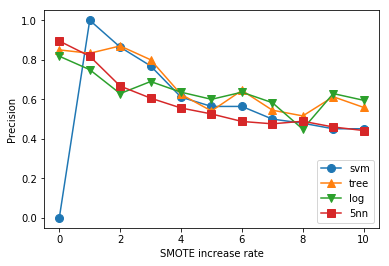

In [44]:
plot_against_inc_rate(bc_precision_dict, measure='Precision', markers=['o', '^', 'v', 's'])

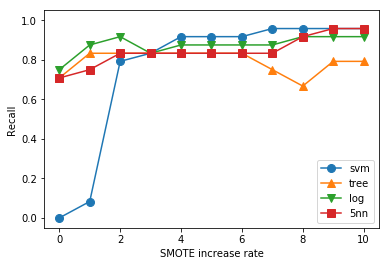

In [45]:
plot_against_inc_rate(bc_recall_dict, 'Recall', markers=['o', '^', 'v', 's'])

#### Iris

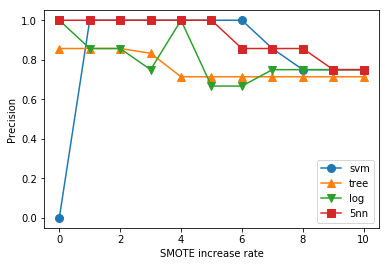

In [46]:
plot_against_inc_rate(iris_precision_dict, 'Precision', markers=['o', '^', 'v', 's'])

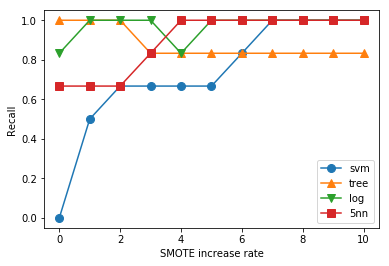

In [47]:
plot_against_inc_rate(iris_recall_dict, 'Recall', markers=['o', '^', 'v', 's'])

#### Wine

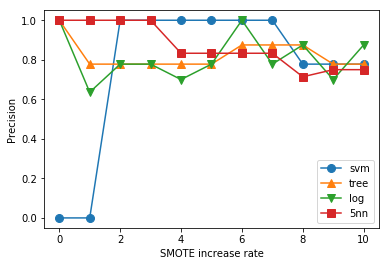

In [48]:
plot_against_inc_rate(wine_precision_dict, 'Precision', markers=['o', '^', 'v', 's'])

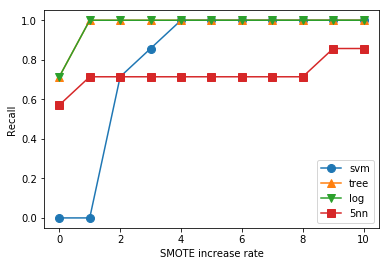

In [49]:
plot_against_inc_rate(wine_recall_dict, 'Recall', markers=['o', '^', 'v', 's'])

#### Yeast

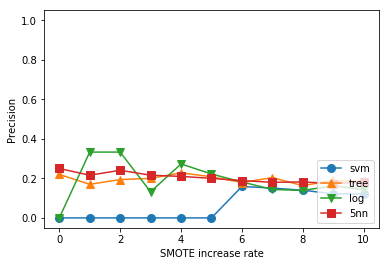

In [50]:
plot_against_inc_rate(yeast_precision_dict, 'Precision', markers=['o', '^', 'v', 's'])

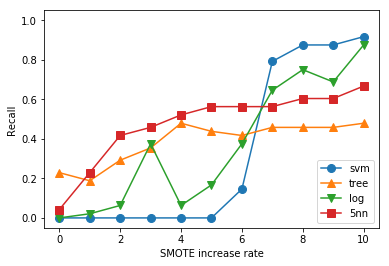

In [51]:
plot_against_inc_rate(yeast_recall_dict, 'Recall', markers=['o', '^', 'v', 's'])

#### Avila

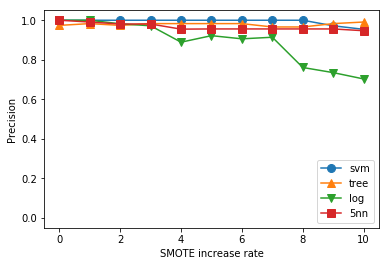

In [52]:
plot_against_inc_rate(avila_precision_dict, 'Precision', markers=['o', '^', 'v', 's'])

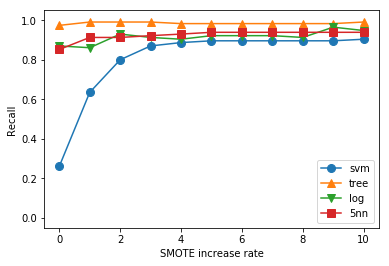

In [53]:
plot_against_inc_rate(avila_recall_dict, 'Recall', markers=['o', '^', 'v', 's'])

### Wireless Indoor Location

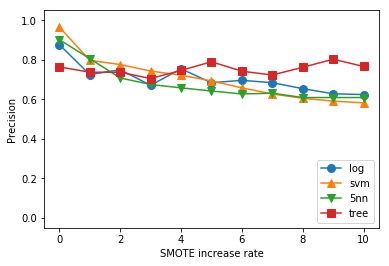

In [19]:
plot_against_inc_rate(wil_precision_dict, 'Precision', markers=['o', '^', 'v', 's'])

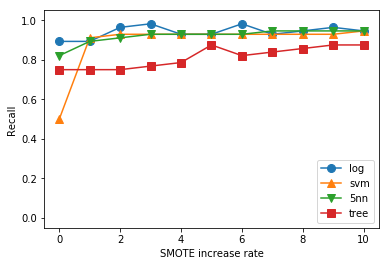

In [20]:
plot_against_inc_rate(wil_recall_dict, 'Recall', markers=['o', '^', 'v', 's'])